In [2]:
%%bash
cd /content/ && git clone https://github.com/ASprabhu/DepthPerception.git

Cloning into 'DepthPerception'...


In [ ]:
!unzip /content/DepthPerception/Data/KITTI_mini.zip -d /content/DepthPerception/Data/.

In [ ]:
### Uncomment if you want to attach drive

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

In [5]:
import torch
import torchvision
import cv2
import numpy as np
import time
import math
import torch.nn as nn

img = cv2.imread("/content/DepthPerception/Data/KITTI_mini/object/training/image_2/000001.png")
# print(img.shape)
trans_img = np.transpose(img, (2, 0, 1))
tens = torch.from_numpy(trans_img)
img_tensor = tens.type(torch.FloatTensor)
img_tensor = img_tensor/255.0

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

start = time.time()
preds = model([img_tensor])
end = time.time()

# print(preds.shape)

In [42]:
'''
Mask RCNN outputs:
n = number of instances detected
[{'boxes' : torch.Size([n, 4]),
  'labels' : torch.Size(n),
  'scores' : torch.Size(n),
  'masks' : torch.Size(n,1,img.shape[0],img.shape[1])
  }]
'''


dict_keys(['boxes', 'labels', 'scores', 'masks'])

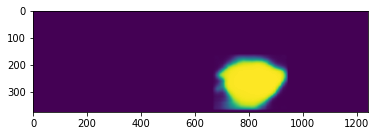

In [41]:
# import matplotlib.pyplot as plt
# m1 = preds[0]['masks'].detach().numpy()
# plt.imshow(m1[1][0])

In [6]:
calib_path = '/content/DepthPerception/Data/KITTI_mini/object/training/calib/000001.txt'
''' Read in a calibration file and parse into a dictionary.
Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
'''
calib_data = {}
with open(calib_path, 'r') as f:
    for line in f.readlines():
        line = line.rstrip()
        if len(line) == 0: continue
        key, value = line.split(':', 1)
        # The only non-float values in these files are dates, which
        # we don't care about anyway
        try:
            calib_data[key] = np.array([float(x) for x in value.split()])
        except ValueError:
            pass

In [7]:
calib_mat = calib_data['P2']
calib_mat = np.transpose(calib_mat.reshape((3,4)))
calib_mat

array([[7.215377e+02, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 7.215377e+02, 0.000000e+00],
       [6.095593e+02, 1.728540e+02, 1.000000e+00],
       [4.485728e+01, 2.163791e-01, 2.745884e-03]])

In [ ]:
label_path = '/content/DepthPerception/Data/KITTI_mini/object/training/label_2/000001.txt'
label = []
with open(label_path,'r') as f:
  for line in f.readlines():
    line = line.rstrip().split(' ')
    print(line[0])
    line = [line[0]] + list(map(float,line[1:]))
    label.append(line)
label

In [20]:
def get_coordinates(n):
  # print(((-1)**(n)))
  x = x_c + ((-1)**(n))*del_x + ((-1)**int(n/4))*del_theta
  y = y_c + ((-1)**int(n/2))*del_y
  z = z_c + ((-1)**int(n/4))*del_z
  # print(x,y,z)
  return [x,y,z,1]

In [21]:
def mbr(arr):
  x_min = min(arr[:,0])
  x_max = max(arr[:,0])
  y_min = min(arr[:,1])
  y_max = max(arr[:,1])
  return torch.FloatTensor([x_min,y_min,x_max,y_max])

In [22]:
coord_3D = []
loss = nn.SmoothL1Loss(beta=1.0)
loss_list = []
param = ['h','w','l','x','c','y','c','z','c','theta']
for i in range(len(label)):
  (h,w,l,x_c,y_c,z_c,theta) = tuple(label[i][8:])
  # coord_3D.append(dict(zip(param,label[i][8:])))
  del_x = w/2
  del_y = h/2
  del_z = l/2
  del_theta = del_z*np.cos(theta)
  coord = []
  for i in range(8):
    temp = get_coordinates(i+1)
    # print(temp)
  coord.append(temp)
  coord_2D = (np.array(coord)@calib_mat)
  coord_2D[:,0] = coord_2D[:,0]/coord_2D[:,2]
  coord_2D[:,1] = coord_2D[:,1]/coord_2D[:,2]
  mbr_e = mbr(coord_2D)
  mbr_p = preds[0]['boxes'][i]
  l1 = loss(mbr_e, mbr_p)
  loss_list.append(l1)

In [23]:
loss_list

[tensor(251.8394, grad_fn=<SmoothL1LossBackward0>),
 tensor(348.4637, grad_fn=<SmoothL1LossBackward0>),
 tensor(219.2679, grad_fn=<SmoothL1LossBackward0>),
 tensor(445.5009, grad_fn=<SmoothL1LossBackward0>),
 tensor(445.5009, grad_fn=<SmoothL1LossBackward0>),
 tensor(445.5009, grad_fn=<SmoothL1LossBackward0>),
 tensor(445.5009, grad_fn=<SmoothL1LossBackward0>)]

In [17]:
# coord = []
# for i in range(8):
#   temp = get_coordinates(i+1)
#   # print(temp)
#   coord.append(temp)


In [18]:
# coord_2D = (np.array(coord)@np.transpose(calib_mat))
# coord_2D[:,0] = coord_2D[:,0]/coord_2D[:,2]
# coord_2D[:,1] = coord_2D[:,1]/coord_2D[:,2]
# coord_2D

In [19]:
# mbr_e = mbr(coord_2D)

In [ ]:
'''
Possible concerns:
1. Pretrained Mask RCNN might not work for us
2. Instances predicted are way more than labels so how can we get the one-to-one correspondance?
3. Mistake in the pipeline?
4. How to treat the DontCare values? What are those?
5. Check get_coordinate function
'''